## Import Librairies


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn


## Read file


In [3]:
file_path = "./data/airline-passengers.csv"

df = pd.read_csv(file_path)
timeseries = []


## Plot time series


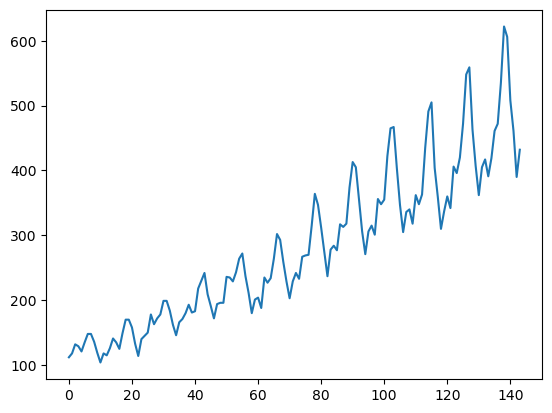

In [4]:
timeseries = df[["Passengers"]].values.astype("float32")
plt.plot(timeseries)
plt.show()


In [5]:
df.head()


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Creating LSTM Model


## train-test split for time series


In [6]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


## Transform a time siries into a Prediction dataset


In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


## Shape verification


In [8]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


/var/folders/sg/wpp92q5907g1lfl4pryzq8740000gn/T/ipykernel_14502/1583174713.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


## Model definition


In [9]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected super() call
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        # extract only the last time step
        x = x[:, -1, :]
        x = self.linear(x)
        return x


# Training and Verifying LSTM model


In [10]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data


## Training the model with RMSE score

In [11]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8
)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


/Users/mesabo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mesabo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mesabo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([95, 1, 1])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensur

Epoch 0: train RMSE 226.1724, test RMSE 422.5970
Epoch 100: train RMSE 189.1602, test RMSE 383.8943
Epoch 200: train RMSE 159.4317, test RMSE 352.0272
Epoch 300: train RMSE 133.0789, test RMSE 322.6169
Epoch 400: train RMSE 110.2844, test RMSE 295.3138
Epoch 500: train RMSE 92.0869, test RMSE 270.4915
Epoch 600: train RMSE 79.7371, test RMSE 249.0424
Epoch 700: train RMSE 73.4978, test RMSE 232.4047
Epoch 800: train RMSE 71.5203, test RMSE 221.9131
Epoch 900: train RMSE 71.1844, test RMSE 217.1989
Epoch 1000: train RMSE 71.2422, test RMSE 215.2078
Epoch 1100: train RMSE 71.3872, test RMSE 212.7363
Epoch 1200: train RMSE 71.4229, test RMSE 211.1437
Epoch 1300: train RMSE 71.3145, test RMSE 209.9198
Epoch 1400: train RMSE 71.3382, test RMSE 209.0328
Epoch 1500: train RMSE 71.3816, test RMSE 208.7645
Epoch 1600: train RMSE 71.4385, test RMSE 208.5902
Epoch 1700: train RMSE 71.3999, test RMSE 208.1743
Epoch 1800: train RMSE 71.4143, test RMSE 207.9947
Epoch 1900: train RMSE 71.3795, test R

## Plotting the output of prediction

In [25]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = y_pred.reshape(-1)

    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

    
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


ValueError: could not broadcast input array from shape (95,) into shape (95,1)

Epoch 0: train RMSE 226.1118, test RMSE 425.3294
Epoch 100: train RMSE 178.6460, test RMSE 375.5850
Epoch 200: train RMSE 142.2593, test RMSE 335.8382
Epoch 300: train RMSE 112.6310, test RMSE 300.8074
Epoch 400: train RMSE 90.4618, test RMSE 270.4091
Epoch 500: train RMSE 66.7527, test RMSE 234.1518
Epoch 600: train RMSE 51.7383, test RMSE 205.1422
Epoch 700: train RMSE 41.5325, test RMSE 180.7605
Epoch 800: train RMSE 34.6980, test RMSE 159.8333
Epoch 900: train RMSE 29.9464, test RMSE 141.8575
Epoch 1000: train RMSE 26.6153, test RMSE 127.1534
Epoch 1100: train RMSE 24.6583, test RMSE 115.0853
Epoch 1200: train RMSE 23.2539, test RMSE 105.8535
Epoch 1300: train RMSE 22.3499, test RMSE 98.1504
Epoch 1400: train RMSE 21.6733, test RMSE 93.0741
Epoch 1500: train RMSE 20.9444, test RMSE 88.4281
Epoch 1600: train RMSE 20.8870, test RMSE 84.5587
Epoch 1700: train RMSE 20.3022, test RMSE 81.6697
Epoch 1800: train RMSE 19.9058, test RMSE 79.0545
Epoch 1900: train RMSE 20.0828, test RMSE 77.

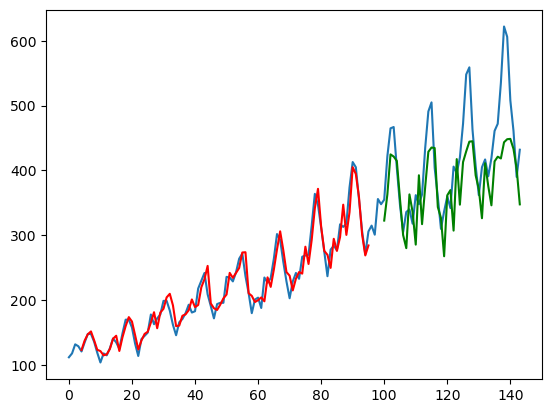

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
 
file_path = "./data/airline-passengers.csv"

df = pd.read_csv(file_path)
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


In [29]:
model


AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)